In [57]:
# importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data

The data has been downloaded from the website: `https://www-2.rotman.utoronto.ca/~hull/ofod/VaRExample/`

In [31]:
# importting the data
df = pd.read_csv("Data/Data.csv")

In [32]:
# showing some entries
df.head()

,Day,Date,DJIA,FTSE 100,CAC 40,Nikkei 225
0,0,07/08/2006,11219.38,11131.84,6373.89,131.77
1,1,08/08/2006,11173.59,11096.28,6378.16,134.38
2,2,09/08/2006,11076.18,11185.35,6474.04,135.94
3,3,10/08/2006,11124.37,11016.71,6357.49,135.44
4,4,11/08/2006,11088.02,11040.73,6364.76,134.10


In [33]:
df.dtypes

Day             int64
Date           object
DJIA          float64
FTSE 100      float64
CAC 40        float64
Nikkei 225    float64
dtype: object

Investment portfolio

Index | Portfolio value
------|---------------
DJIA   | 4000
FTSE   | 3000
CAC 40 | 1000
Nikkei 225 | 2000
Total  | 10000

In [34]:
investment_instock = [4000, 3000, 1000, 2000]

# Historical approach

In [35]:
df.columns.tolist()

['Day', 'Date', 'DJIA', 'FTSE 100', 'CAC 40', 'Nikkei 225']

In [36]:
# list down the stock names (here first two columns are Day and Date, so removing that give you stock list)
stocklist =df.columns.tolist()[2:]
stocklist

['DJIA', 'FTSE 100', 'CAC 40', 'Nikkei 225']

In [37]:
stock_dict = {}
print('Stock', 'Investment')
for st, inv in zip(stocklist, investment_instock):
    stock_dict[st] = inv
    print(st,'-> ', '$',inv)

Stock Investment
DJIA ->  $ 4000
FTSE 100 ->  $ 3000
CAC 40 ->  $ 1000
Nikkei 225 ->  $ 2000


In [38]:
# populated a dictionary with stock and investment
stock_dict

{'DJIA': 4000, 'FTSE 100': 3000, 'CAC 40': 1000, 'Nikkei 225': 2000}

In [39]:
df.head(5)

,Day,Date,DJIA,FTSE 100,CAC 40,Nikkei 225
0,0,07/08/2006,11219.38,11131.84,6373.89,131.77
1,1,08/08/2006,11173.59,11096.28,6378.16,134.38
2,2,09/08/2006,11076.18,11185.35,6474.04,135.94
3,3,10/08/2006,11124.37,11016.71,6357.49,135.44
4,4,11/08/2006,11088.02,11040.73,6364.76,134.10


## Implemented exactly like John.C.Hull book

In [40]:
def calibrate_lastday(row, dataframe, colname):
    if row.name == 0:
        return 0 # for the first column
                # A warning to use: the first row must be with index 0, which might not always the case so use `reset_index` to safeguard this 
    else:
        return (row[colname] / dataframe.at[row.name - 1, colname]) *   dataframe.at[500, colname]

df1 = df.copy()
df1.rename(columns={'Day': 'Scenario'},inplace=True)
df1.drop(columns=['Date'], inplace=True)

for st in stocklist:
    df1.loc[:, st] = df.apply(lambda row: calibrate_lastday(row, df1, st), axis=1)
df1.drop(index=0, inplace=True)
df1.loc[:, "Portfolio value"] = 4000 * df1["DJIA"]/df.at[500, "DJIA"] + 3000 * df1["FTSE 100"]/df.at[500, "FTSE 100"] +\
                               1000 * df1["CAC 40"]/df.at[500, "CAC 40"] + 2000 * df1["Nikkei 225"]/df.at[500, "Nikkei 225"]
df1["Portfolio loss"] = 10000 -  df1["Portfolio value"]
df1.head(5)

,Scenario,DJIA,FTSE 100,CAC 40,Nikkei 225,Portfolio value,Portfolio loss
1,1,10977.075328,9569.233691,6204.553775,115.054653,10014.375756,-14.375756
2,2,10925.971020,9676.958536,6293.607814,114.129713,10027.459819,-27.459819
3,3,11070.014536,9455.163614,6088.776250,112.405038,9946.813664,53.186336
4,4,10986.044308,9620.830895,6207.490362,111.703795,9974.826743,25.173257
5,5,11031.851405,9659.695423,6265.582154,114.561517,10063.624705,-63.624705


It is not matching exactly digit by digit because of the calculation is done in the final state, which  gives round off disagreement w.r.t earlier

## Simpler approach

In [41]:
## Method 1
def calculate_daily_return(row, dataframe, colname):
    if row.name == 0:
        return 0 # for the first column
                # A warning to use: the first row must be with index 0, which might not always the case so use `reset_index` to safeguard this 
    else:
        return row[colname] / dataframe.at[row.name - 1, colname] -1

df.reset_index(inplace = True,  drop = True) # to safegurard to use the function `calculate_daily_return`
for key in stock_dict:
    df.loc[:, key+"_return"] = df.apply(lambda row: calculate_daily_return(row, df, key), axis=1)

def calculate_daily_loss(row, dataframe):
    total = 0
    for key in stock_dict:
        total += -row[key+'_return'] * stock_dict[key]
    return total

df.loc[:, "Portfolio loss"] = df.apply(lambda row: calculate_daily_loss(row, df), axis=1)
df.head()

,Day,Date,DJIA,FTSE 100,CAC 40,Nikkei 225,DJIA_return,FTSE 100_return,CAC 40_return,Nikkei 225_return,Portfolio loss
0,0,07/08/2006,11219.38,11131.84,6373.89,131.77,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,08/08/2006,11173.59,11096.28,6378.16,134.38,-0.004081,-0.003194,0.000670,0.019807,-14.375756
2,2,09/08/2006,11076.18,11185.35,6474.04,135.94,-0.008718,0.008027,0.015033,0.011609,-27.459819
3,3,10/08/2006,11124.37,11016.71,6357.49,135.44,0.004351,-0.015077,-0.018003,-0.003678,53.186336
4,4,11/08/2006,11088.02,11040.73,6364.76,134.10,-0.003268,0.002180,0.001144,-0.009894,25.173257


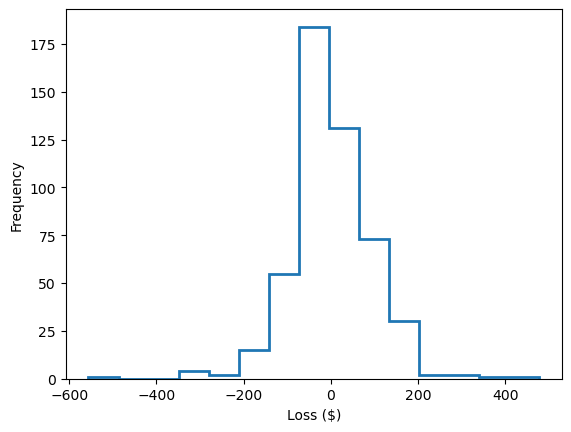

In [42]:
plt.hist(df["Portfolio loss"], bins = 15, histtype="step", lw=2)
plt.xlabel("Loss ($)")
plt.ylabel("Frequency")
plt.show()

### VaR 1 day, using python quantile

In [43]:
print( "VaR 1 day $",df["Portfolio loss"].quantile(0.99))

VaR 1 day $ 217.97104094571608


### VaR 1 day, manual counting

In [44]:
### Manually calculating, the 5th day loss (500 entries / 100 * 1 (percentile) = 5th day loss)
dfvar = df.sort_values(by="Portfolio loss", ascending=False)
onepercentile = dfvar.reset_index(drop=True).loc[int(df.shape[0] / 100)-1 ,'Portfolio loss']
print( "VaR 1 day $",onepercentile )

VaR 1 day $ 253.3445778480283


### Fitting (?)

Fitting the loss profile with a normal distribution and calculating  $\mu$, $\sigma$ accurately, should give better estimate?

This explored in the Covariance approach, where the mean, and sigma are calculated using the data. 

1 day VaR (1% CL) = $2.33 \times \sigma + \mu$ 


1 day VaR (5% CL) = $1.64 \times \sigma + \mu$ 



### 10 day VaR

10 day VaR  = $\sqrt 10 \times $ 1 day VaR 

# Covariance approach

In [84]:
Returns_df = df[[i+'_return' for i in list(stock_dict.keys())]].drop(index=0)
Covariance_Matrix = Returns_df.cov()
Correlation_Matrix  =Returns_df.corr() # for visualization

In [89]:
import seaborn as sns

In [93]:
Correlation_Matrix

,DJIA_return,FTSE 100_return,CAC 40_return,Nikkei 225_return
DJIA_return,1.000000,0.489106,0.495711,-0.061762
FTSE 100_return,0.489106,1.000000,0.918108,0.200939
CAC 40_return,0.495711,0.918108,1.000000,0.210859
Nikkei 225_return,-0.061762,0.200939,0.210859,1.000000


<AxesSubplot:>

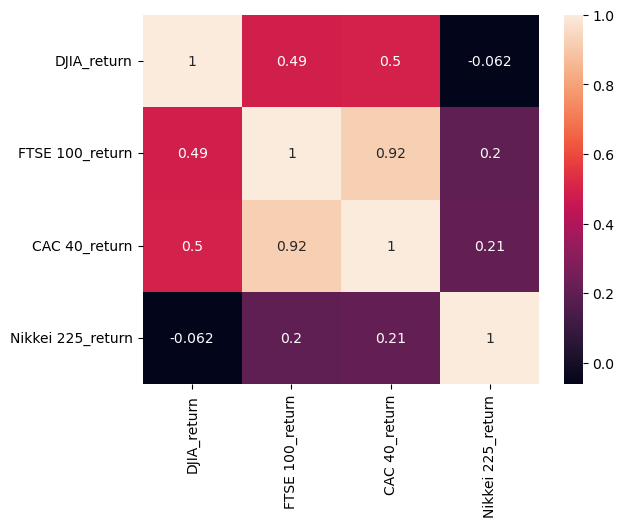

In [95]:
sns.heatmap(Correlation_Matrix, annot=True)

In [86]:
alpha = np.array([stock_dict[i] for i in stock_dict.keys()])

In [87]:
Protfolio_variance = alpha.T.dot(Covariance_Matrix).dot(alpha)
print("portfolio variance $",Protfolio_variance)

portfolio variance $ 8779.996911097678


In [88]:
Protfolio_Sigma = np.sqrt(Protfolio_variance)
print("portfolio SD $",Protfolio_Sigma)

portfolio SD $ 93.70163771833275


In [98]:
print("Portfolio VaR, 1 day", Protfolio_Sigma * 2.33)
print("Portfolio VaR, 10 day", Protfolio_Sigma * 2.33 * np.sqrt(10))

Portfolio VaR, 1 day 218.3248158837153
Portfolio VaR, 10 day 690.4036879294475


## Portfolio management, different scenario

### only investing to the first stock DJIA

In [142]:
alpha_other = np.array([10000,0,0,0]) # 

In [143]:
Protfolio_variance = alpha_other.T.dot(Covariance_Matrix).dot(alpha_other)
print("portfolio variance $",Protfolio_variance)

Protfolio_Sigma = np.sqrt(Protfolio_variance)
print("portfolio SD $",Protfolio_Sigma)

print("Portfolio VaR, 1 day", Protfolio_Sigma * 2.33)
print("Portfolio VaR, 10 day", Protfolio_Sigma * 2.33 * np.sqrt(10))

portfolio variance $ 12295.243760724265
portfolio SD $ 110.88392020813598
Portfolio VaR, 1 day 258.3595340849568
Portfolio VaR, 10 day 817.0045829283699


### Equally investing to the all four stocks

In [144]:
alpha_other = np.array([2500,2500,2500,2500]) # 

In [145]:
Protfolio_variance = alpha_other.T.dot(Covariance_Matrix).dot(alpha_other)
print("portfolio variance $",Protfolio_variance)

Protfolio_Sigma = np.sqrt(Protfolio_variance)
print("portfolio SD $",Protfolio_Sigma)

print("Portfolio VaR, 1 day", Protfolio_Sigma * 2.33)
print("Portfolio VaR, 10 day", Protfolio_Sigma * 2.33 * np.sqrt(10))

portfolio variance $ 9527.286568669744
portfolio SD $ 97.60782022291936
Portfolio VaR, 1 day 227.4262211194021
Portfolio VaR, 10 day 719.1848583823994


### Optimized portfolio (My thought + chatgpt)

The portfolio variance is $\alpha^{T} . \Sigma . \alpha $, now we have $\Sigma$ the covariance matrix, lets minimize the variance

In [134]:
import cvxpy as cp
import numpy as np

# Define data
cov_matrix = Covariance_Matrix
expected_returns = np.array([0.8, 0.4, 0.5, 0.6])
target_return = 0.05

# Define variables
w = cp.Variable(len(expected_returns))

# Define objective function
objective = cp.Minimize(cp.quad_form(w, cov_matrix))


# Define constraints
constraints = [w @ expected_returns >= target_return, cp.sum(w) == 1, w >= 0]


# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()


# Optimal weights
optimal_weights = w.value
print("Optimal Weights:", optimal_weights)



Optimal Weights: [0.55923129 0.03777656 0.02307912 0.37991304]


In [137]:
alpha_optimized = 10000 * np.array(optimal_weights)

In [141]:
Protfolio_variance = alpha_optimized.T.dot(Covariance_Matrix).dot(alpha_optimized)
print("portfolio variance $",Protfolio_variance)

Protfolio_Sigma = np.sqrt(Protfolio_variance)
print("portfolio SD $",Protfolio_Sigma)

print("Portfolio VaR, 1 day", Protfolio_Sigma * 2.33)
print("Portfolio VaR, 10 day", Protfolio_Sigma * 2.33 * np.sqrt(10))

portfolio variance $ 6984.007069806232
portfolio SD $ 83.57037196163621
Portfolio VaR, 1 day 194.7189666706124
Portfolio VaR, 10 day 615.7554383135488


## Pricipal component

In [150]:
eigenvalues, eigenvectors = np.linalg.eigh(Covariance_Matrix)
indices = np.argsort(eigenvalues)[::-1]

eigenvalues = eigenvalues[indices]
eigenvectors = eigenvectors[:,indices]

In [151]:
eigenvalues

array([4.30825429e-04, 1.88269689e-04, 7.57686301e-05, 1.62143300e-05])

In [152]:
eigenvectors

array([[-0.32023065, -0.30964098,  0.89518739, -0.01464004],
       [-0.65826808, -0.0783234 , -0.27396557, -0.69677217],
       [-0.64927859, -0.06823369, -0.24413775,  0.71706223],
       [-0.20633172,  0.94516246,  0.25294103, -0.01076949]])

what to do with negative values? Positive symetrix matrix, why not positive eigenvector?

# Monte Carlo Simulation

# Resources

* A good recourse: [link](https://blog.quantinsti.com/calculating-covariance-matrix-portfolio-variance/)